In [96]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing, linear_model
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

data = pd.read_csv("..\\CO2_Emissions_Canada.csv", delimiter=',')
data["Vehicle Class"] = data["Vehicle Class"].astype("category")
data["Model"] = data["Model"].astype("category")
data["Make"] = data["Make"].astype("category")
data["Transmission"] = data["Transmission"].astype("category")
print(data.tail(5))

       Make        Model   Vehicle Class  Engine Size(L)  Cylinders  \
7380  VOLVO  XC40 T5 AWD     SUV - SMALL             2.0          4   
7381  VOLVO  XC60 T5 AWD     SUV - SMALL             2.0          4   
7382  VOLVO  XC60 T6 AWD     SUV - SMALL             2.0          4   
7383  VOLVO  XC90 T5 AWD  SUV - STANDARD             2.0          4   
7384  VOLVO  XC90 T6 AWD  SUV - STANDARD             2.0          4   

     Transmission Fuel Type  Fuel Consumption City (L/100 km)  \
7380          AS8         Z                              10.7   
7381          AS8         Z                              11.2   
7382          AS8         Z                              11.7   
7383          AS8         Z                              11.2   
7384          AS8         Z                              12.2   

      Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
7380                              7.7                               9.4   
7381                            

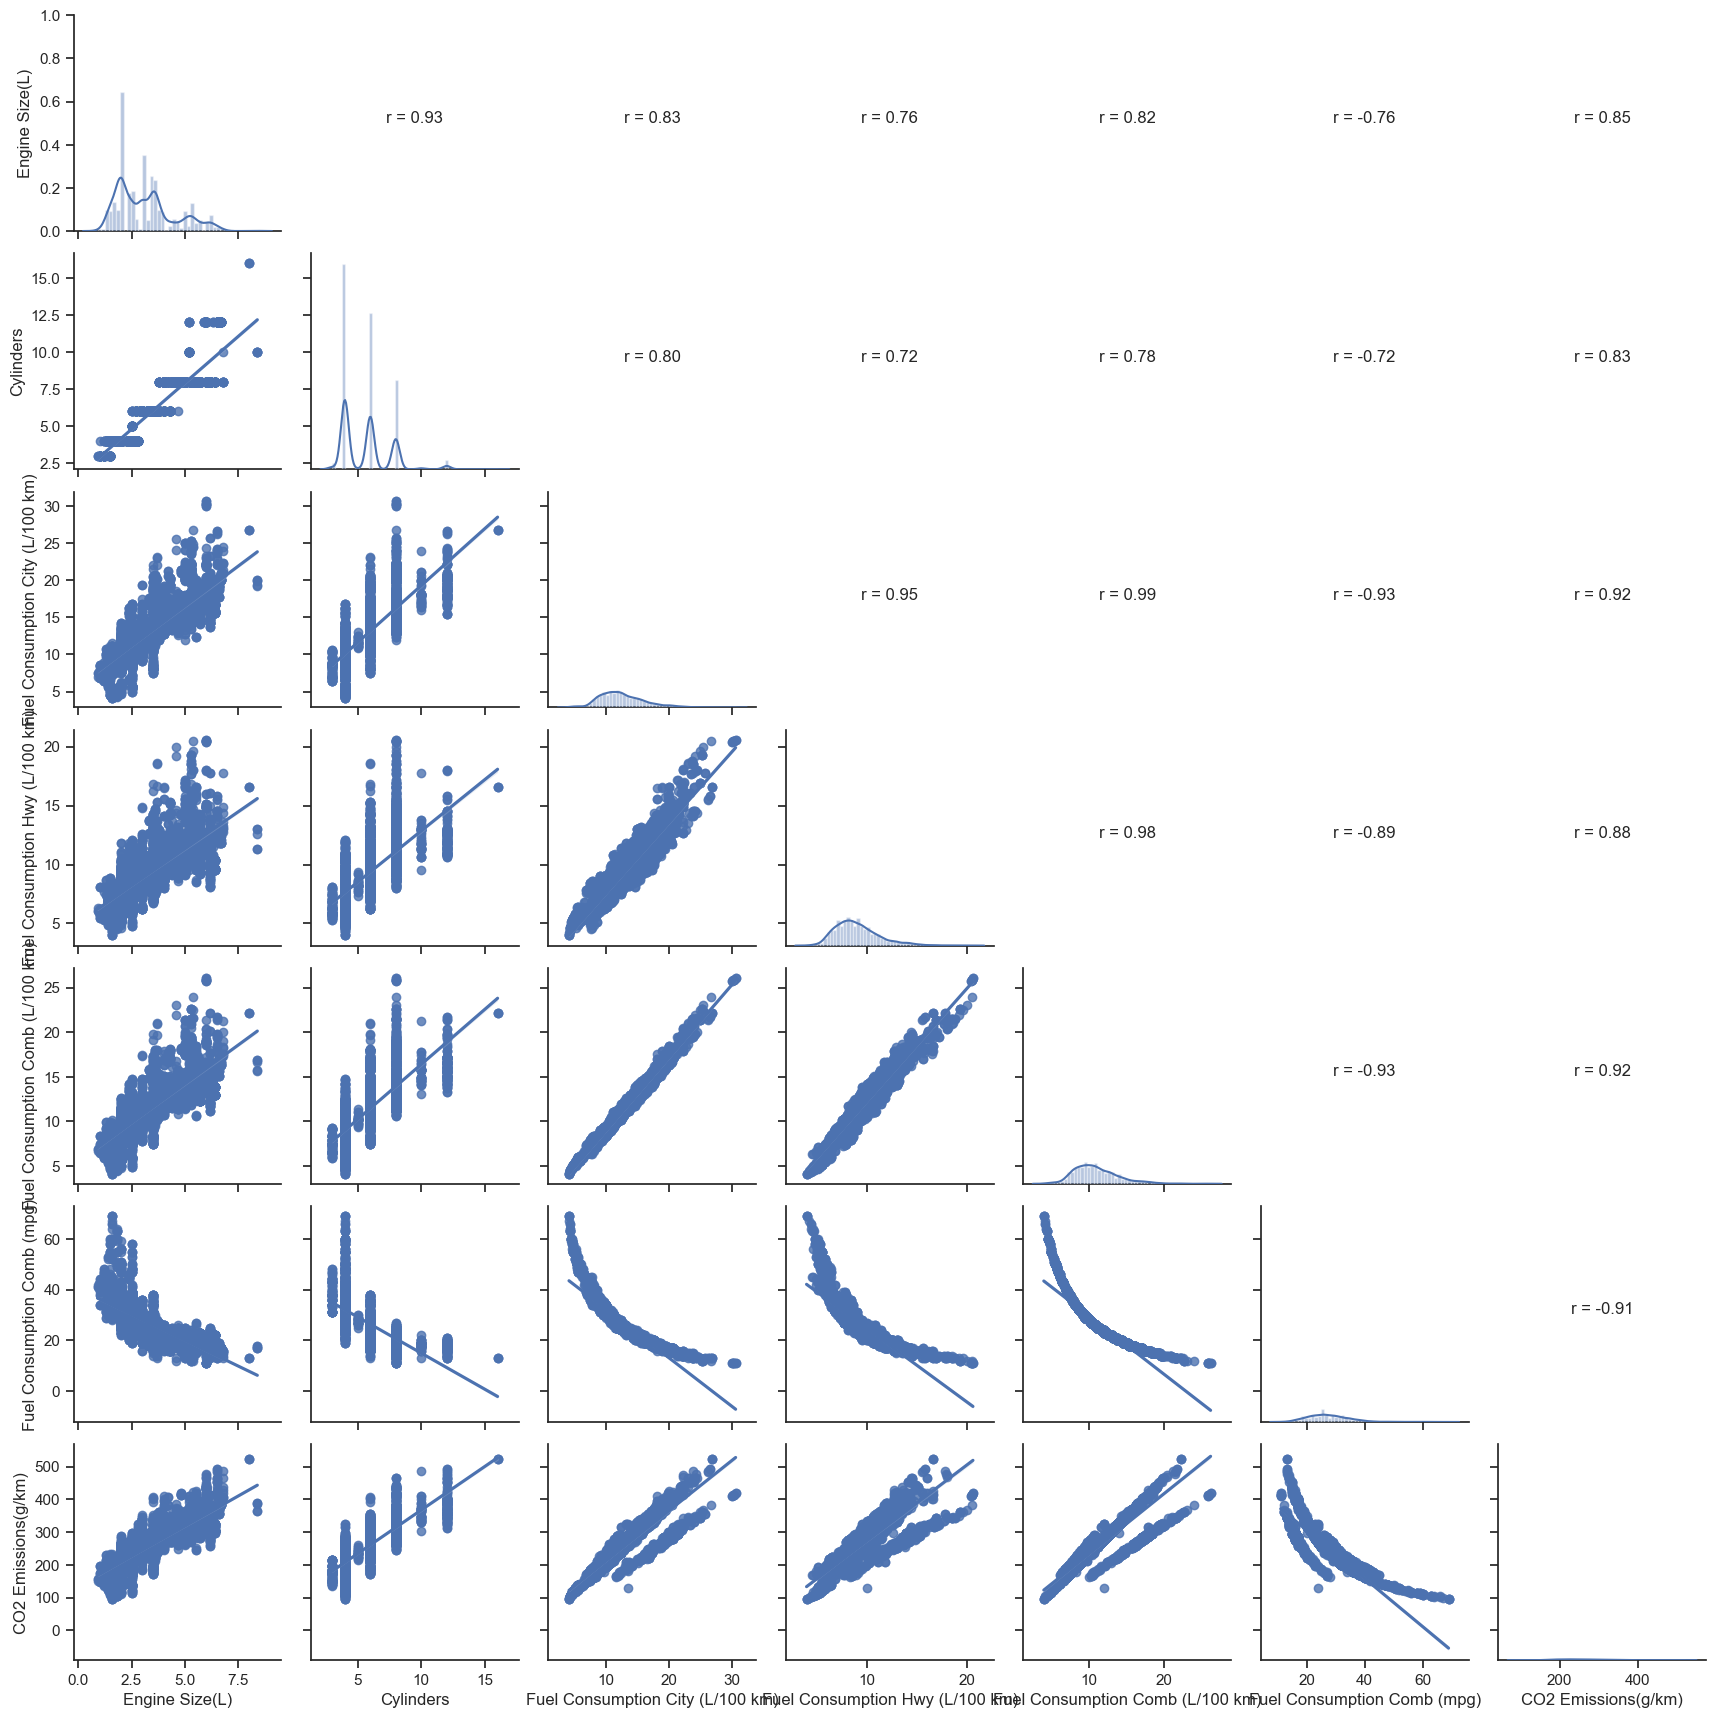

In [91]:
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r, _ = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

sns.set_theme(style="ticks")
g = sns.PairGrid(data, palette=["b", "r", "g", "y", "orange"])
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)
plt.show()

In [92]:
#data transformation
le = preprocessing.LabelEncoder()
data["Make"] = le.fit_transform(data["Make"])
data["Model"] = le.fit_transform(data["Model"])
data["Vehicle Class"] = le.fit_transform(data["Vehicle Class"])
data["Transmission"] = le.fit_transform(data["Transmission"])
data["Fuel Type"] = le.fit_transform(data["Fuel Type"])

#Transform CO2Emissions into classification variable by splitting them into HIGH(0) and LOW(1)
co2_mean = round(data["CO2 Emissions(g/km)"].mean(), 0)

def categorizeCO2(x):
    if x >= co2_mean:
        return 0
    else:
        return 1

data["CO2 Emissions(g/km)"] = data["CO2 Emissions(g/km)"].apply(categorizeCO2)

In [93]:
#Setting random state for reproducibility
random_state=12345

feature_cols = ['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type', "Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)"]
#feature_cols = ['Make', 'Model', 'Vehicle Class', 'Transmission', 'Fuel Type']
X = data[feature_cols]
y = data["CO2 Emissions(g/km)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

lgr = linear_model.LinearRegression().fit(X_train, y_train)
lgr_pred = lgr.predict(X_test)

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
lda_pred = lda.predict(X_test)
lda_prob = lda.predict_proba(X_test)[:,1]

logreg = LogisticRegression(solver='liblinear', random_state=random_state).fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)

#scores = cross_val_score(lda, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

print ("Accuracy Score of the model: " + str(round(lda.score(X_test, y_test) * 100, 2)) + "%")

Accuracy Score of the model: 91.43%


Text(0, 0.5, 'Predictions')

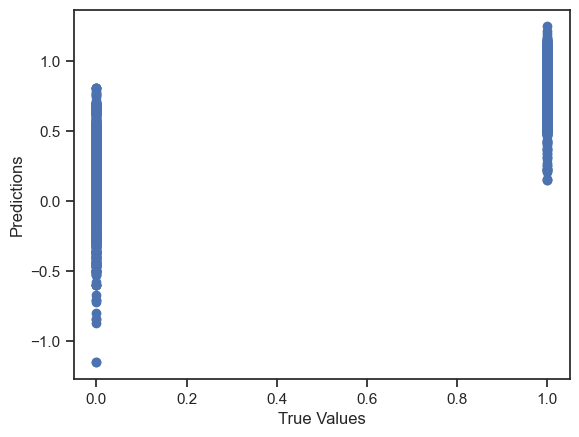

In [94]:
plt.scatter(y_test, lgr_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [95]:
lda_cfm = confusion_matrix(y_test, lda_pred)
lda_acc = round(accuracy_score(y_test, lda_pred), 4)

print(lda_cfm)
print(lda_acc)

[[ 981  156]
 [  53 1248]]
0.9143


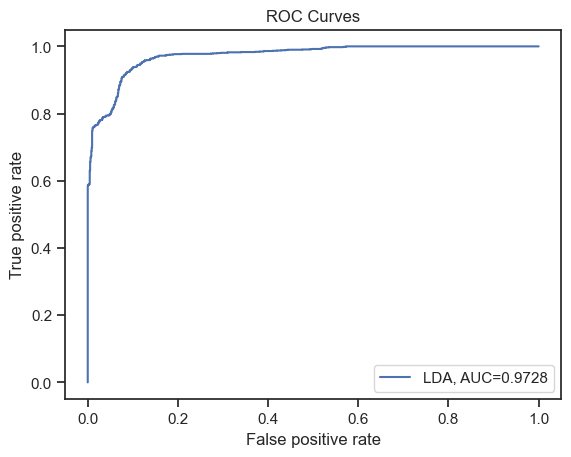

In [97]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, lda_prob)
lda_auc = round(metrics.roc_auc_score(y_test, lda_prob), 4)
plt.plot(fpr, tpr, label="LDA, AUC="+str(lda_auc))

plt.title("ROC Curves")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()